In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import sys
sys.path.append('/Users/mtwheeler/USF/spring_1/data_systems/final_project/repo/')
sys.path.append('/Users/mtwheeler/USF/spring_1/data_systems/final_project/repo/etl_pipeline')

from etl_pipeline.mongo_db import MongoDB
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np

In [3]:
mongo = MongoDB()

In [4]:
locations_df = pd.read_csv('../etl_pipeline/locations.csv')
locations = locations_df[['lat', 'lon']].values

In [5]:
dates = pd.date_range(datetime(2022, 1, 1, 0, 0, 0), datetime(2022, 12, 31, 23, 0, 0), freq='H')
dates = [date for date in dates if date.hour > 4 and date.hour < 20]
dates = np.array([date.to_pydatetime().strftime('%Y-%m-%d_%H:%M:%S') for date in dates])

In [6]:
np.random.seed(123)

NUM_LOC = 50
NUM_DATES = 3000


indices = []

loc_idx = np.random.choice(range(len(locations)), NUM_LOC, replace=False)
for lat, lon in locations[loc_idx]:
    date_idx = np.random.choice(range(len(dates)), NUM_DATES, replace=False)
    for date in dates[date_idx]:
        indices.append(f'{lat}_{lon}_{date}')


In [7]:
data = mongo.collection.find({"_id": {"$in": indices}}, {})
data = pd.DataFrame(list(data))
data.to_csv('sample_dataset.csv')

In [8]:
def create_time_embedding(time, embedding_num):
    hour = datetime.strptime(time, '%H:%M:%S').hour
    if embedding_num == 0:
        return np.sin(2 * np.pi * hour / 24)
    elif embedding_num == 1:
        return np.cos(2 * np.pi * hour / 24)
    
def create_date_embedding(date, embedding_num):
    day = (datetime.strptime(date, '%Y-%m-%d') - datetime(2022, 1, 1)).days
    if embedding_num == 0:
        return np.sin(2 * np.pi * day / 365)
    elif embedding_num == 1:
        return np.cos(2 * np.pi * day / 365)
    
def compute_sunset_sunrise_time(time, sunrise, sunset):
    time = datetime.strptime(time, '%H:%M:%S')
    sunrise = datetime.strptime(sunrise, '%H:%M:%S')
    sunset = datetime.strptime(sunset, '%H:%M:%S')
    time_min = time.minute + time.hour * 60
    sunrise_min = sunrise.minute + sunrise.hour * 60
    sunset_min = sunset.minute + sunset.hour * 60
    if time_min < sunrise_min or sunset_min < time_min:
        return 0
    else:
        return 2 * min(time_min - sunrise_min, sunset_min - time_min) / (sunset_min - sunrise_min)

In [9]:
data['time_emb_0'] = data['time'].apply(lambda x: create_time_embedding(x, 0))
data['time_emb_1'] = data['time'].apply(lambda x: create_time_embedding(x, 1))

data['date_emb_0'] = data['date'].apply(lambda x: create_date_embedding(x, 0))
data['date_emb_1'] = data['date'].apply(lambda x: create_date_embedding(x, 1))

data['time_sunset_sunrise'] = data.apply(lambda x: compute_sunset_sunrise_time(x['time'], x['day_agg_sunrise'], x['day_agg_sunset']), axis=1)

data

,_id,datetimeEpoch,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,day_agg_sunset,day_agg_moonphase,day_agg_conditions,day_agg_description,day_agg_source,time_emb_0,time_emb_1,date_emb_0,date_emb_1,time_sunset_sunrise
0,32.802_-116.96_2022-01-01_05:00:00,1641042000,9.9,8.8,82.30,7.1,0.0,0.0,0.0,0.0,...,16:52:45,0.97,Partially cloudy,Clearing in the afternoon.,obs,9.659258e-01,2.588190e-01,0.000000,1.000000,0.000000
1,32.802_-116.96_2022-01-01_08:00:00,1641052800,11.9,11.9,76.47,7.9,0.0,0.0,0.0,0.0,...,16:52:45,0.97,Partially cloudy,Clearing in the afternoon.,obs,8.660254e-01,-5.000000e-01,0.000000,1.000000,0.232558
2,32.802_-116.96_2022-01-01_09:00:00,1641056400,13.7,13.7,64.94,7.2,0.0,0.0,0.0,0.0,...,16:52:45,0.97,Partially cloudy,Clearing in the afternoon.,obs,7.071068e-01,-7.071068e-01,0.000000,1.000000,0.431894
3,32.802_-116.96_2022-01-01_13:00:00,1641070800,17.0,17.0,46.03,5.3,0.0,0.0,0.0,0.0,...,16:52:45,0.97,Partially cloudy,Clearing in the afternoon.,obs,-2.588190e-01,-9.659258e-01,0.000000,1.000000,0.770764
4,32.802_-116.96_2022-01-01_14:00:00,1641074400,16.8,16.8,54.93,7.7,0.0,0.0,0.0,0.0,...,16:52:45,0.97,Partially cloudy,Clearing in the afternoon.,obs,-5.000000e-01,-8.660254e-01,0.000000,1.000000,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,40.718_-122.326_2022-12-31_12:00:00,1672516800,12.3,12.3,88.25,10.4,0.0,0.0,0.0,0.0,...,16:51:43,0.29,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,obs,1.224647e-16,-1.000000e+00,-0.017213,0.999852,0.956989
149996,40.718_-122.326_2022-12-31_13:00:00,1672520400,11.7,11.7,89.67,10.1,0.0,0.0,0.0,0.0,...,16:51:43,0.29,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,obs,-2.588190e-01,-9.659258e-01,-0.017213,0.999852,0.827957
149997,40.718_-122.326_2022-12-31_17:00:00,1672534800,10.5,10.5,91.05,9.1,0.0,0.0,0.0,0.0,...,16:51:43,0.29,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,obs,-9.659258e-01,-2.588190e-01,-0.017213,0.999852,0.000000
149998,40.718_-122.326_2022-12-31_18:00:00,1672538400,10.5,10.5,85.16,8.1,0.0,0.0,0.0,0.0,...,16:51:43,0.29,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,obs,-1.000000e+00,-1.836970e-16,-0.017213,0.999852,0.000000


In [10]:
pca_values = pd.read_csv('PCA_lat_lon.csv')

In [11]:
final = data.merge(pca_values.drop(columns=['city_name']), on=['lat','lon'])

In [19]:
feature_columns = [
    "temp", "feelslike", "humidity", "dew", "precip", "precipprob", "snow", 
    "snowdepth", "windgust", "windspeed", "pressure", "visibility", 
    "cloud_cover_perc", "severerisk", "lat", "lon", "time_emb_0", 
    "time_emb_1", "date_emb_0", "date_emb_1", "time_sunset_sunrise", "PC1", "PC2"
]

target_column = 'solar_radiation'

In [20]:
X = final[feature_columns].values
y = final[target_column].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [29]:
y_test_hat = model.predict(X_test)

In [30]:
mean_absolute_percentage_error()

690988191547381.1

In [35]:
np.mean(np.abs(y_test_hat - y_test))

46.37864553333334

In [38]:
mean_absolute_error(y_test, y_test_hat)

46.37864553333334

<AxesSubplot: >

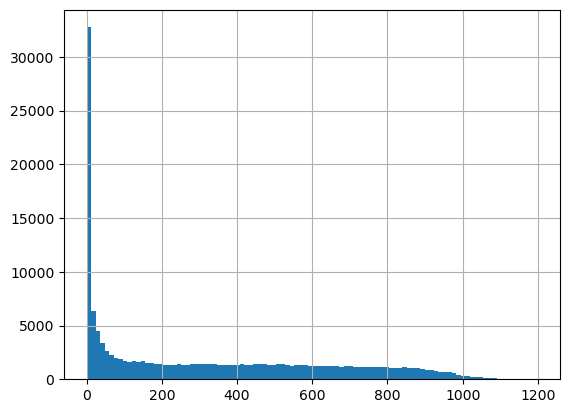

In [42]:
final[target_column].hist(bins=100)

In [44]:
sorted(list(zip(model.feature_importances_, feature_columns)))

[(3.7872871419107044e-06, 'snow'),
 (7.781483217195404e-05, 'snowdepth'),
 (0.00025707175941403404, 'precipprob'),
 (0.0008200975412767989, 'severerisk'),
 (0.0010408419418000906, 'precip'),
 (0.003127198210040734, 'visibility'),
 (0.003208260616894144, 'time_emb_1'),
 (0.0053227183283518845, 'time_emb_0'),
 (0.0066621415692836175, 'windgust'),
 (0.00679008135734071, 'temp'),
 (0.007079921364429092, 'dew'),
 (0.007109356626142913, 'windspeed'),
 (0.00747576088888974, 'pressure'),
 (0.008849330349563717, 'feelslike'),
 (0.011152547096360921, 'PC1'),
 (0.012713926090573922, 'lon'),
 (0.016250097363886322, 'PC2'),
 (0.018964833293655416, 'date_emb_0'),
 (0.020983388519674545, 'lat'),
 (0.026974961187406266, 'humidity'),
 (0.04020478360081207, 'cloud_cover_perc'),
 (0.07382139119373086, 'date_emb_1'),
 (0.7211096889811583, 'time_sunset_sunrise')]